In [2]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2

from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"font.size":12})

import pandas as pd
import pickle as pkl
import numpy as np
from time import time

import glob
import itertools

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GroupKFold, cross_validate
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from M1_util_train_test import load_model, test
import mnl
import linear_reg
from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo_v1, train_test_split_data
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.style.use('ggplot') # set the style; or "ggplot", "dark_background", "classic";
plt.rcParams.update({'font.size': 16})

In [4]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'
output_dim = 3
model_run_date = '2208'
v2 = 1

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

# Load Model Embeddings

In [5]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+
                       "_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [6]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Demographics

In [11]:
# demographic variables

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

demo_cs, demo_np = load_demo_v1(data_dir, norm = 'minmax')
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))

demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)
demo = train_test_split_data(demo, data_version)

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone', #'pct_nonwhite',
         'pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

x = demo[demo_variables].to_numpy(dtype=float)

groups = demo['train_test']
group_split = GroupKFold(n_splits=5)

In [17]:
x = np.hstack([x, aggregate_embeddings])

# Load Trip Behavior

In [27]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, str(len(unique_ct)))

y = df_pivot[variable_names].to_numpy()[:, :4]


# 1. Linear Regression

## 1.1 Auto

In [9]:
y_index = 1

In [19]:
# Lasso
for a in (1e-4)*np.array([0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.251e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.033e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-05 	 Train score: 0.9971 	 Cross val score: 0.3445 	 Nonzero coef: 3228


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e+00, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.389e+00, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-04 	 Train score: 0.8754 	 Cross val score: 0.5113 	 Nonzero coef: 759


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e+00, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e+00, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 2.00e-04 	 Train score: 0.7565 	 Cross val score: 0.5784 	 Nonzero coef: 327


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.362e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.027e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 3.00e-04 	 Train score: 0.6914 	 Cross val score: 0.5919 	 Nonzero coef: 171


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.286e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.251e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 4.00e-04 	 Train score: 0.6552 	 Cross val score: 0.5938 	 Nonzero coef: 103


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 5.00e-04 	 Train score: 0.6360 	 Cross val score: 0.5914 	 Nonzero coef: 70


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 6.00e-04 	 Train score: 0.6237 	 Cross val score: 0.5873 	 Nonzero coef: 57


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 7.00e-04 	 Train score: 0.6150 	 Cross val score: 0.5840 	 Nonzero coef: 51


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.997e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 8.00e-04 	 Train score: 0.6074 	 Cross val score: 0.5801 	 Nonzero coef: 46


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.754e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-03 	 Train score: 0.5940 	 Cross val score: 0.5722 	 Nonzero coef: 34


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e-02, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.766e-03, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 2.00e-03 	 Train score: 0.5337 	 Cross val score: 0.5203 	 Nonzero coef: 18
Parameter: 5.00e-03 	 Train score: 0.4626 	 Cross val score: 0.4516 	 Nonzero coef: 12


## 1.2 PT 

In [20]:
y_index=3

In [21]:
# Lasso
for a in (1e-4)*np.array([0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e-01, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e-01, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-05 	 Train score: 0.9857 	 Cross val score: 0.1331 	 Nonzero coef: 2220


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e-01, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-04 	 Train score: 0.6759 	 Cross val score: 0.4313 	 Nonzero coef: 309


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e-02, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.881e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 2.00e-04 	 Train score: 0.5434 	 Cross val score: 0.4637 	 Nonzero coef: 84


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.752e-02, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 3.00e-04 	 Train score: 0.5064 	 Cross val score: 0.4580 	 Nonzero coef: 46


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e-02, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.357e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 4.00e-04 	 Train score: 0.4842 	 Cross val score: 0.4492 	 Nonzero coef: 34


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.964e-03, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 5.00e-04 	 Train score: 0.4662 	 Cross val score: 0.4368 	 Nonzero coef: 27


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e-03, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 6.00e-04 	 Train score: 0.4535 	 Cross val score: 0.4298 	 Nonzero coef: 21


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.192e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e-03, tolerance: 1.210e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 7.00e-04 	 Train score: 0.4434 	 Cross val score: 0.4233 	 Nonzero coef: 18


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e-03, tolerance: 1.210e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.400e-03, tolerance: 1.281e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 8.00e-04 	 Train score: 0.4375 	 Cross val score: 0.4193 	 Nonzero coef: 17


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-03, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e-03, tolerance: 1.286e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 1.00e-03 	 Train score: 0.4283 	 Cross val score: 0.4127 	 Nonzero coef: 16
Parameter: 2.00e-03 	 Train score: 0.3772 	 Cross val score: 0.3672 	 Nonzero coef: 11
Parameter: 5.00e-03 	 Train score: 0.2075 	 Cross val score: 0.2044 	 Nonzero coef: 1


## 1.3 Active

In [22]:
y_index=0

In [23]:
# Lasso
for a in (1e-4)*np.array([0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.668e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.930e-01, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-05 	 Train score: 0.9942 	 Cross val score: 0.1778 	 Nonzero coef: 2913


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+00, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.746e-01, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-04 	 Train score: 0.7961 	 Cross val score: 0.4139 	 Nonzero coef: 585


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.618e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.632e-01, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 2.00e-04 	 Train score: 0.6408 	 Cross val score: 0.4638 	 Nonzero coef: 226


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.369e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e-01, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 3.00e-04 	 Train score: 0.5628 	 Cross val score: 0.4713 	 Nonzero coef: 112


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.044e-01, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 4.00e-04 	 Train score: 0.5255 	 Cross val score: 0.4684 	 Nonzero coef: 61


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.701e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 5.00e-04 	 Train score: 0.5091 	 Cross val score: 0.4650 	 Nonzero coef: 44


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.518e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 6.00e-04 	 Train score: 0.4980 	 Cross val score: 0.4612 	 Nonzero coef: 38


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.141e-02, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.741e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 7.00e-04 	 Train score: 0.4877 	 Cross val score: 0.4566 	 Nonzero coef: 33


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.755e-02, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.168e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 8.00e-04 	 Train score: 0.4784 	 Cross val score: 0.4508 	 Nonzero coef: 28


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-02, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-03 	 Train score: 0.4591 	 Cross val score: 0.4365 	 Nonzero coef: 24
Parameter: 2.00e-03 	 Train score: 0.4051 	 Cross val score: 0.3934 	 Nonzero coef: 12
Parameter: 5.00e-03 	 Train score: 0.3329 	 Cross val score: 0.3274 	 Nonzero coef: 5


# 2. MNL

In [30]:
from util_aggregate_models import mnl_torch

# dataloader and model definition

lr_list = [0.0001, 0.0002]
wd_list = [0.1, 0.01, 0.001, 0.0001]

results = {}
for i in range(5):
    
    train_filter = groups != i
    test_filter = groups == i
    x_train = x[train_filter]
    y_train = y[train_filter]
    x_test = x[test_filter]
    y_test = y[test_filter]
    sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
    sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)
    
    trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    ret_dict = mnl_torch(trainloader, testloader, x_train.shape[-1], sst_train, sst_test, lr_list=lr_list, wd_list=wd_list)
    
    results[i] = ret_dict
    

[lr: 1.00e-04, wd: 1.00e-01]
[epoch: 995] Train KL loss: 0.135 Train R2 score: 0.512 0.594 0.015 0.451 
[epoch: 995] Test KL loss: 0.144 Test R2 score: 0.494 0.590 -0.011 0.422 

[lr: 1.00e-04, wd: 1.00e-02]
[epoch: 995] Train KL loss: 0.136 Train R2 score: 0.489 0.588 0.017 0.480 
[epoch: 995] Test KL loss: 0.144 Test R2 score: 0.484 0.588 -0.011 0.433 

[lr: 1.00e-04, wd: 1.00e-03]
[epoch: 995] Train KL loss: 0.136 Train R2 score: 0.493 0.590 0.028 0.460 
[epoch: 995] Test KL loss: 0.144 Test R2 score: 0.490 0.588 -0.014 0.428 

[lr: 1.00e-04, wd: 1.00e-04]
[epoch: 995] Train KL loss: 0.136 Train R2 score: 0.490 0.590 0.026 0.478 
[epoch: 995] Test KL loss: 0.144 Test R2 score: 0.487 0.588 -0.015 0.433 

[lr: 2.00e-04, wd: 1.00e-01]
Diverging. stop.
[epoch:  35] Train KL loss: 0.188 Train R2 score: 0.203 0.264 -0.030 0.212 
[epoch:  35] Test KL loss: 0.196 Test R2 score: 0.151 0.253 -0.034 0.222 

[lr: 2.00e-04, wd: 1.00e-02]
Diverging. stop.
[epoch:  35] Train KL loss: 0.194 Train R

In [31]:
df = []

for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))


pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss')

,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
0,0.0001,0.1000,0.135269,0.145609,0.596259,0.500021,0.475562,0.557258,0.452492,0.427976
1,0.0001,0.0100,0.136264,0.145804,0.591027,0.490323,0.480119,0.555728,0.447794,0.428981
2,0.0001,0.0010,0.136934,0.146204,0.589605,0.493532,0.458733,0.554233,0.449044,0.421792
5,0.0002,0.0100,0.144748,0.154107,0.536809,0.444513,0.429313,0.502423,0.402650,0.379812
6,0.0002,0.0010,0.145220,0.156580,0.538940,0.444150,0.419119,0.502011,0.389693,0.366211
3,0.0001,0.0001,0.149216,0.157355,0.510182,0.414454,0.408719,0.480846,0.386853,0.384464
4,0.0002,0.1000,0.155222,0.163712,0.474246,0.381530,0.385296,0.444137,0.349600,0.346487
7,0.0002,0.0001,0.169133,0.180997,0.387798,0.312015,0.327007,0.341268,0.231982,0.289366


In [13]:
# Lasso
train_r2 = []
test_r2 = []
demo_nonzero = []
embed_nonzero = []

regs = (1e-4)*np.array([0,0.1,0.2,0.4,0.6,0.8,1,2,10,20,50])

for a in regs:

    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, auto_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d, %d" % 
          (a, lasso.score(x_train, auto_train), 
          lasso.score(x_test, auto_test), 
          np.sum(lasso.coef_[:dim_demo] != 0), 
          np.sum(lasso.coef_[dim_demo:] != 0)))
    train_r2.append(lasso.score(x_train, auto_train))
    test_r2.append(lasso.score(x_test, auto_test))
    demo_nonzero.append(np.sum(lasso.coef_[:dim_demo] != 0))
    embed_nonzero.append(np.sum(lasso.coef_[dim_demo:] != 0))

#     with open(out_dir+"AllModels_A_LR.csv", "a") as f:
#         f.write("%s,%.6f,%s,%.4f,%.4f,%s,%d,%d\n" % ('Demo+AE',a,'auto',
#             lasso.score(x_train, auto_train), lasso.score(x_test, auto_test), 'LR', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

<ipython-input-13-090637e82962>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(x_train, auto_train)
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: 0.2814 	 Nonzero coef: 10, 18432


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 1.00e-05 Train R2: 0.9963 	 Test R: 0.3373 	 Nonzero coef: 9, 3579


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 2.00e-05 Train R2: 0.9873 	 Test R: 0.3959 	 Nonzero coef: 9, 2531


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.661e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 4.00e-05 Train R2: 0.9596 	 Test R: 0.4591 	 Nonzero coef: 9, 1679


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.668e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 6.00e-05 Train R2: 0.9242 	 Test R: 0.5012 	 Nonzero coef: 8, 1256


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.600e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 8.00e-05 Train R2: 0.8881 	 Test R: 0.5495 	 Nonzero coef: 7, 980


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 1.00e-04 Train R2: 0.8534 	 Test R: 0.5838 	 Nonzero coef: 7, 799


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.071e+00, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 2.00e-04 Train R2: 0.7288 	 Test R: 0.6491 	 Nonzero coef: 6, 335


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.861e-01, tolerance: 7.704e-03
  model = cd_fast.enet_coordinate_descent(


Parameter: 1.00e-03 Train R2: 0.5666 	 Test R: 0.5895 	 Nonzero coef: 5, 33
Parameter: 2.00e-03 Train R2: 0.5267 	 Test R: 0.5568 	 Nonzero coef: 3, 15
Parameter: 5.00e-03 Train R2: 0.4603 	 Test R: 0.4770 	 Nonzero coef: 3, 10


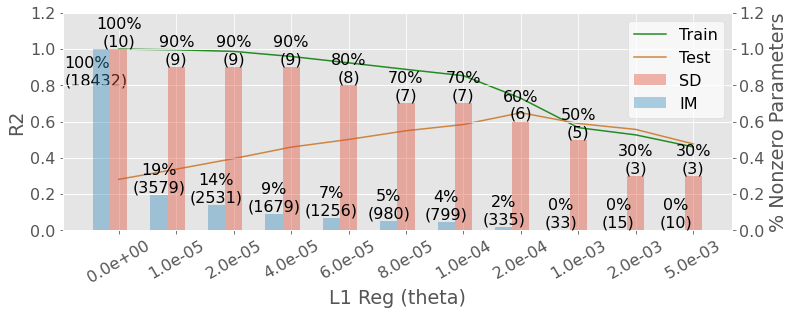

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax2 = ax.twinx()
ax2.bar(np.arange(len(regs)), np.array(demo_nonzero)/10, width=0.3, alpha=0.4, label='SD')
ax2.bar(np.arange(len(regs))-.3, np.array(embed_nonzero)/18432, width=0.3, alpha=0.4, label='IM')
labels1 = []
labels2 = []
for a, b in zip(np.array(demo_nonzero)/10, np.array(embed_nonzero)/18432):
    labels1+=["{:.0%}\n({:})".format(a, int(10*a))] 
    if b == 1:
        labels2+=[""]
    else:
        labels2+=["{:.0%}\n({:})".format(b, int(18432*b))] 

for c,l in zip(ax2.containers, [labels1, labels2]):
    ax2.bar_label(c, labels=l)

ax.plot(np.arange(len(regs)), train_r2, linewidth=1.5, label="Train",c="forestgreen")
ax.plot(np.arange(len(regs)), test_r2, linewidth=1.5, label="Test",c="peru")

ln1,lb1 = ax.get_legend_handles_labels()
ln2,lb2 = ax2.get_legend_handles_labels()

ax.annotate("100%\n(18432)", (-0.95,0.8))

ax.set_xticks(np.arange(len(regs)))
ax.set_ylabel("R2") 
ax.set_xlabel("L1 Reg (theta)")
ax2.set_ylabel("% Nonzero Parameters")
ax.set_xticklabels(["%.1e" % a for a in regs], rotation=30)

# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1e'))

ax.set_ylim([0,1.2])
ax2.set_ylim([0,1.2])


ax2.legend(ln1+ln2, lb1+lb2, facecolor='white', framealpha=0.7, loc=1)

In [27]:
fig.savefig(out_dir+"l1_reg.png", bbox_inches='tight')